In [47]:
#import necessary package
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import kagglehub

# general setting. do not change TEST_SIZE
RANDOM_SEED = 42
TEST_SIZE = 0.3

In [48]:
# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
data['Class'] = data['Class'].astype(int)

# prepare data
data = data.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


In [49]:
#fraud/Non-Fraud Transactions

fraud = data[data['Class'] == 1]
nonfraud = data[data['Class'] == 0]
print(f'Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}')
print(f'the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)')


Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


In [ ]:
!pip install imbalanced-learn

In [50]:
#監督式學習(XGboost)
X = data.drop('Class', axis=1)
Y = data['Class']
# 分割訓練資料
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                            test_size=TEST_SIZE,
                            random_state=RANDOM_SEED,
                            #stratify=Y
                            )  # 加 stratify 保持比例
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [14]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.1 MB/s eta 0:00:00


In [65]:
# XGboost模型
# 使用 scale_pos_weight 對不平衡類別進行加權
from xgboost import XGBClassifier
scale_pos_weight = len(nonfraud) / len(fraud)

#xgb_p = {'max_depth': 8, 'learning_rate': 0.10878760307404967, 'n_estimators': 222, 'subsample': 0.9751385897199043, 'colsample_bytree': 0.9531383469930996, 'scale_pos_weight': 0.3760386045860146, 'gamma': 0.0032257177733947037}
#+0.00004 +0.02 +0 +0.002
xgb_p = {'max_depth': 6, 'learning_rate': 0.13042046559796128, 'n_estimators': 239, 'subsample': 0.8734341721479638, 'colsample_bytree': 0.9573714080077769, 'scale_pos_weight': 0.39978732376580606, 'gamma': 0.14893186350468346}
# Comparing eg Model and my Model:
# =============================================
# Accuracy Difference (my Model - eg Model): 0.000047
# Precision Difference (my Model - eg Model): 0.016807
# Recall Difference (my Model - eg Model): 0.014706
# F1 Difference (my Model - eg Model): 0.015686
#xgb_p = {'max_depth': 6, 'learning_rate': 0.1955769145592336, 'n_estimators': 295, 'subsample': 0.836727099029087, 'colsample_bytree': 0.9676128706382335, 'scale_pos_weight': 0.27347884102107767, 'gamma': 0.050343301349559666}

xgb_model = XGBClassifier(
  **xgb_p,
  eval_metric='logloss',
  tree_method='hist',
  random_state=RANDOM_SEED

)
#xgb_model.fit(X_train_std, y_train)
xgb_model.fit(
    X_train_std, y_train,
    eval_set=[(X_test_std, y_test)],
    #early_stopping_rounds=10,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9573714080077769, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.14893186350468346, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13042046559796128,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=239, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [66]:
# evaluate
# define evaluation function
def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'\n{model_name} Evaluation:')
    print('===' * 15)
    print('         Accuracy:', accuracy)
    print('  Precision Score:', precision)
    print('     Recall Score:', recall)
    print('         F1 Score:', f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return 0.2 * accuracy + 0.2 * precision + 0.3 * recall + 0.3 * f1

#predict and print result
# y_pred = rf_model.predict(X_test)
# print(classification_report(y_test, y_pred))
# evaluation(y_test, y_pred)

y_prob = xgb_model.predict_proba(X_test_std)[:, 1]
threshold = 0.43
y_pred_custom = (y_prob > threshold).astype(int)

evaluation(y_test, y_pred_custom, model_name="XGBoost")


XGBoost Evaluation:
         Accuracy: 0.9996839998595555
  Precision Score: 0.957983193277311
     Recall Score: 0.8382352941176471
         F1 Score: 0.8941176470588236

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.96      0.84      0.89       136

    accuracy                           1.00     85443
   macro avg       0.98      0.92      0.95     85443
weighted avg       1.00      1.00      1.00     85443



0.9112393209803145

In [67]:
def compare_scores(score_set1, score_set2, set1_name="Set 1", set2_name="Set 2"):
    """
    比較兩組分數並計算差值。

    Args:
        score_set1 (object): 包含 Accuracy, Precision, Recall, F1 屬性的物件或字典。
        score_set2 (object): 包含 Accuracy, Precision, Recall, F1 屬性的物件或字典。
        set1_name (str): 第一組分數的名稱。
        set2_name (str): 第二組分數的名稱。
    """
    scores_to_compare = ['Accuracy', 'Precision', 'Recall', 'F1']
    differences = {}

    print(f"\nComparing {set1_name} and {set2_name}:")
    print("===" * 15)

    for score_name in scores_to_compare:
        try:
            score1 = getattr(score_set1, score_name) if not isinstance(score_set1, dict) else score_set1[score_name]
            score2 = getattr(score_set2, score_name) if not isinstance(score_set2, dict) else score_set2[score_name]
            difference = score2 - score1
            differences[score_name] = difference
            print(f"{score_name} Difference ({set2_name} - {set1_name}): {difference:.6f}")
        except (AttributeError, KeyError):
            print(f"Warning: '{score_name}' not found in one or both score sets.")

# 使用範例:
# 範例分數
class ScoreSet1:
    Accuracy = 0.9996371850239341
    Precision = 0.9411764705882353
    Recall = 0.8235294117647058
    F1 = 0.8784313725490196

# 假設你有第二組分數 (你可以替換成其他模型的結果)
class ScoreSet2:
    Accuracy =  0.9996839998595555
    Precision = 0.957983193277311
    Recall = 0.8382352941176471
    F1 = 0.8941176470588236

compare_scores(ScoreSet1, ScoreSet2, set1_name="eg Model", set2_name="my Model")


Comparing eg Model and my Model:
Accuracy Difference (my Model - eg Model): 0.000047
Precision Difference (my Model - eg Model): 0.016807
Recall Difference (my Model - eg Model): 0.014706
F1 Difference (my Model - eg Model): 0.015686


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


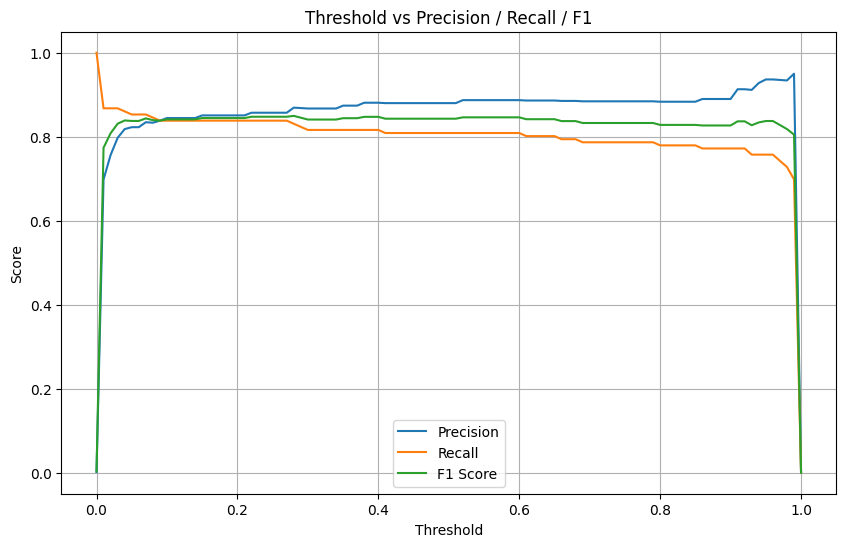

最佳閾值: 0.28, F1=0.8496, Precision=0.8692, Recall=0.8309


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_thresholds(y_true, y_proba, plot=True):
    thresholds = np.arange(0.0, 1.01, 0.01)
    precisions, recalls, f1s = [], [], []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))

    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(thresholds, precisions, label='Precision')
        plt.plot(thresholds, recalls, label='Recall')
        plt.plot(thresholds, f1s, label='F1 Score')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Threshold vs Precision / Recall / F1')
        plt.legend()
        plt.grid(True)
        plt.show()

    best_idx = np.argmax(f1s)
    print(f'最佳閾值: {thresholds[best_idx]:.2f}, F1={f1s[best_idx]:.4f}, Precision={precisions[best_idx]:.4f}, Recall={recalls[best_idx]:.4f}')

    return thresholds[best_idx], precisions[best_idx], recalls[best_idx], f1s[best_idx]

# 使用範例
y_proba = xgb_model.predict_proba(X_test)[:,1]
best_thresh, best_prec, best_rec, best_f1 = evaluate_thresholds(y_test, y_proba)


[I 2025-05-29 04:00:44,264] A new study created in memory with name: no-name-bf32c882-7291-4124-9588-6ffb80176b63

[I 2025-05-29 04:03:33,328] Trial 9 finished with value: 0.8860342069644395 and parameters: {'max_depth': 6, 'learning_rate': 0.13073900458253496, 'n_estimators': 216, 'subsample': 0.8795906808110288, 'colsample_bytree': 0.9539407860134127, 'scale_pos_weight': 0.2826163576092304, 'gamma': 1.5700872143780704}. Best is trial 6 with value: 0.9178720004408077.

[I 2025-05-29 04:03:58,651] Trial 10 finished with value: 0.9971509971509972 and parameters: {'max_depth': 7, 'learning_rate': 0.19733280667100336, 'n_estimators': 271, 'subsample': 0.9877576219856867, 'colsample_bytree': 0.9002024774959728, 'scale_pos_weight': 0.31664179483514143, 'gamma': 0.05486450103502194}. Best is trial 10 with value: 0.9971509971509972.

[I 2025-05-29 04:04:30,646] Trial 11 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.1987963766087025, 'n_estimators': 270, 'subsample': 0.987968381060042, 'colsample_bytree': 0.9034493078709679, 'scale_pos_weight': 0.31989355008325593, 'gamma': 0.007006614923179319}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:04:58,999] Trial 12 finished with value: 0.9971509971509972 and parameters: {'max_depth': 7, 'learning_rate': 0.19904700348954668, 'n_estimators': 265, 'subsample': 0.9925415431726549, 'colsample_bytree': 0.9261365112943445, 'scale_pos_weight': 0.32132143421555476, 'gamma': 0.06127238372175035}. Best is trial 11 with value: 1.0.


[I 2025-05-29 04:05:26,984] Trial 13 finished with value: 0.9899975544142823 and parameters: {'max_depth': 7, 'learning_rate': 0.17487994918649039, 'n_estimators': 299, 'subsample': 0.9414722885909675, 'colsample_bytree': 0.905140267424663, 'scale_pos_weight': 0.3035100155753025, 'gamma': 0.11406000107192771}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:07:32,495] Trial 20 finished with value: 0.9308415264579648 and parameters: {'max_depth': 8, 'learning_rate': 0.18562824676941647, 'n_estimators': 235, 'subsample': 0.8634936761295126, 'colsample_bytree': 0.9107096588912859, 'scale_pos_weight': 0.3047805095630465, 'gamma': 0.5502091681204713}. Best is trial 11 with value: 1.0.
[I 2025-05-29 04:08:03,918] Trial 21 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.19803457049807333, 'n_estimators': 265, 'subsample': 0.9981809633015376, 'colsample_bytree': 0.9271103795607166, 'scale_pos_weight': 0.3172155238924506, 'gamma': 0.003991415308148136}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:10:46,268] Trial 29 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.19059248822690206, 'n_estimators': 246, 'subsample': 0.9692612128291711, 'colsample_bytree': 0.9438785027278944, 'scale_pos_weight': 0.35993236098169945, 'gamma': 0.0004700867216537192}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:11:22,142] Trial 31 finished with value: 0.9589828105617579 and parameters: {'max_depth': 7, 'learning_rate': 0.19337448835167553, 'n_estimators': 254, 'subsample': 0.9718887259897316, 'colsample_bytree': 0.9430628379513869, 'scale_pos_weight': 0.34078201879469483, 'gamma': 0.27911042307251777}. Best is trial 11 with value: 1.0.
[I 2025-05-29 04:11:51,329] Trial 32 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.18267075250836848, 'n_estimators': 265, 'subsample': 0.9350204091939208, 'colsample_bytree': 0.9236039017547109, 'scale_pos_weight': 0.37170148298609856, 'gamma': 0.03180403368630983}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:12:37,398] Trial 34 finished with value: 0.9620632478272172 and parameters: {'max_depth': 7, 'learning_rate': 0.10064574634449144, 'n_estimators': 249, 'subsample': 0.8993005788852667, 'colsample_bytree': 0.919756569816461, 'scale_pos_weight': 0.36647955436814855, 'gamma': 0.33107971645993345}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:13:12,743] Trial 36 finished with value: 0.9680505810634251 and parameters: {'max_depth': 6, 'learning_rate': 0.19986642170469832, 'n_estimators': 266, 'subsample': 0.8833327402639254, 'colsample_bytree': 0.9101809508852166, 'scale_pos_weight': 0.3998437913317391, 'gamma': 0.424646251772509}. Best is trial 11 with value: 1.0.
[I 2025-05-29 04:13:42,898] Trial 37 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.194919060693422, 'n_estimators': 251, 'subsample': 0.8350801581303386, 'colsample_bytree': 0.9511170771243059, 'scale_pos_weight': 0.37288121635401794, 'gamma': 0.010271505042842303}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:14:34,261] Trial 40 finished with value: 0.9604773312147091 and parameters: {'max_depth': 7, 'learning_rate': 0.17223468432913655, 'n_estimators': 232, 'subsample': 0.9534410645038307, 'colsample_bytree': 0.9379724066066523, 'scale_pos_weight': 0.38815457793070207, 'gamma': 0.3618385237502445}. Best is trial 11 with value: 1.0.
[I 2025-05-29 04:15:03,560] Trial 41 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.19482816508104112, 'n_estimators': 254, 'subsample': 0.8155187149674066, 'colsample_bytree': 0.9530888089814088, 'scale_pos_weight': 0.3720054976287543, 'gamma': 0.010875742671696453}. Best is trial 11 with value: 1.0.
[I 2025-05-29 04:15:28,555] Trial 42 finished with value: 0.9886036790475319 and parameters: {'max_depth': 7, 'learning_rate': 0.1935693078822655, 'n_estimators': 254, 'subsample': 0.7802403405845928, 'colsample_bytree': 0.9602003111072765, 'scale_pos_weight': 0.35440881719613165, 'gamma': 0.22673746703773157}. Best is trial 11 with value: 1.0.

[I 2025-05-29 04:16:07,179] Trial 44 finished with value: 0.9871483981043125 and parameters: {'max_depth': 7, 'learning_rate': 0.18856345756434068, 'n_estimators': 269, 'subsample': 0.853831375184437, 'colsample_bytree': 0.9468543731597264, 'scale_pos_weight': 0.3906432626100069, 'gamma': 0.2586753385804108}. Best is trial 11 with value: 1.0.
[I 2025-05-29 04:16:35,073] Trial 45 finished with value: 1.0 and parameters: {'max_depth': 7, 'learning_rate': 0.1999931195999449, 'n_estimators': 262, 'subsample': 0.7844659764848596, 'colsample_bytree': 0.9572506907925785, 'scale_pos_weight': 0.3584793292402978, 'gamma': 0.01133256168456295}. Best is trial 11 with value: 1.0.
[I 2025-05-29 04:16:53,427] Trial 46 finished with value: 0.9260315155324822 and parameters: {'max_depth': 7, 'learning_rate': 0.1412494268941686, 'n_estimators': 222, 'subsample': 0.8395822957608421, 'colsample_bytree': 0.9691596971824518, 'scale_pos_weight': 0.31648334428934904, 'gamma': 0.7090654308077826}. Best is trial 11 with value: 1.0.

408365261397714}. Best is trial 11 with value: 1.0.
最佳參數： {'max_depth': 7, 'learning_rate': 0.1987963766087025, 'n_estimators': 270, 'subsample': 0.987968381060042, 'colsample_bytree': 0.9034493078709679, 'scale_pos_weight': 0.31989355008325593, 'gamma': 0.007006614923179319}
最佳 F1 分數： 1.0

In [46]:
#SMOTE optuma
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import optuna
from google.colab import drive
drive.mount('/content/drive')
storage_path = '/content/drive/MyDrive/optuna_study.db'

def objective_with_smote(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 6, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 200, 300),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.2, 0.4),  # 可固定為 1 因為 SMOTE 後類別平衡
        'eval_metric': 'logloss',
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': RANDOM_SEED,
        'tree_method': 'hist',
        #'use_label_encoder': False
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    scores = []

    for train_idx, val_idx in skf.split(X_train_std, y_train):
        X_fold_train, X_fold_val = X_train_std[train_idx], X_train_std[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Apply SMOTE on current fold's training data
        # sm = SMOTE(random_state=RANDOM_SEED)
        # X_res, y_res = sm.fit_resample(X_fold_train, y_fold_train)

        model = XGBClassifier(
            **params,
            )

        model.fit(X_train_std, y_train)

        y_proba = model.predict_proba(X_fold_val)[:, 1] #預測機率

        best_score = 0
        for threshold in np.arange(0.1, 0.9, 0.05):
            y_pred = (y_proba > threshold).astype(int)
            precision = precision_score(y_fold_val, y_pred)
            recall = recall_score(y_fold_val, y_pred)
            f1 = f1_score(y_fold_val, y_pred)
            score = f1*recall* precision
            if score > best_score:
                best_score = score
        scores.append(best_score)

    return np.mean(scores)

study = optuna.create_study(
    study_name='xgboost1',  # Give your study a name
    storage='sqlite:///' + storage_path,
    load_if_exists=True,
    direction='maximize'
)
study.optimize(objective_with_smote, n_trials=300)

print("最佳參數：", study.best_params)
print("最佳 F1 分數：", study.best_value)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2025-05-29 05:23:39,996] A new study created in RDB with name: xgboost1
[I 2025-05-29 05:24:10,187] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 8, 'learning_rate': 0.13021674628303642, 'n_estimators': 250, 'subsample': 0.8953104387475361, 'colsample_bytree': 0.9879194507904189, 'scale_pos_weight': 0.3946958448838549, 'gamma': 0.08189273203738356}. Best is trial 0 with value: 1.0.
[I 2025-05-29 05:24:24,794] Trial 1 finished with value: 0.6875916106699744 and parameters: {'max_depth': 6, 'learning_rate': 0.14254006427472277, 'n_estimators': 211, 'subsample': 0.8285219945407262, 'colsample_bytree': 0.9982972700637163, 'scale_pos_weight': 0.3218951182950331, 'gamma': 3.394794420002707}. Best is trial 0 with value: 1.0.
[I 2025-05-29 05:24:42,080] Trial 2 finished with value: 0.7442588270194671 and parameters: {'max_depth': 7, 'learning_rate': 0.1855480369678379, 'n_estimators': 275, 'subsample': 0.9864266551062482, 'colsample_bytree': 0.9592210841693101, 'scale_pos_w

最佳參數： {'max_depth': 8, 'learning_rate': 0.13021674628303642, 'n_estimators': 250, 'subsample': 0.8953104387475361, 'colsample_bytree': 0.9879194507904189, 'scale_pos_weight': 0.3946958448838549, 'gamma': 0.08189273203738356}
最佳 F1 分數： 1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')